In [4]:
%config IPCompleter.greedy = True
#System
import time
import re
import itertools
import string
#processing
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.preprocessing import MultiLabelBinarizer

#feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn_pandas import DataFrameMapper, cross_val_score

#classifiers
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier, Perceptron, RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

#Evaluation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, fbeta_score
from sklearn.model_selection import train_test_split

#Report
import matplotlib.pyplot as plt   
import seaborn as sns


In [5]:
#load data
dataFrameTraining = pd.read_csv("data/Toxic_train_set.csv")
dataFrameTesting = pd.read_csv("data/Toxic_test_set.csv")

dftr = dataFrameTraining
dfte = dataFrameTesting

all_categories = ["obscene", "threat", "insult", "hate", "Intolerant"]

In [6]:
data = pd.concat([dftr, dfte], ignore_index=True )

In [7]:
stopWords = nltk.corpus.stopwords.words('english')
new_stop_words = ['?','!',',','.',';','&','>','<',')','(','/','\'s','\'\'','``']
stopWords.extend(new_stop_words)
new_stop_words_1 = ['I','thi','He','We','hi','everi','like','boy','march']
stopWords.extend(new_stop_words_1)

ps = nltk.PorterStemmer()

In [8]:
#for countvectorizer
def comment_clean_cv(comment):
    comment = "".join([word.lower() for word in comment if word not in string.punctuation])
    tokens = re.split('\W+', comment)
    comment = [ps.stem(word) for word in tokens if word not in stopWords]
    return comment

In [9]:
def comment_clean_ngram(comment):
    comment = "".join([word.lower() for word in comment if word not in string.punctuation])
    tokens = re.split('\W+', comment)
    comment = " ".join([ps.stem(word) for word in tokens if word not in stopWords])
    return comment

#dftr['Comments'] = dftr['Comments'].apply(lambda x: comment_clean_ngram(x))

In [10]:
data['comment_length'] = data['Comments'].apply(lambda x: len(x) - x.count(" "))

In [11]:
def polarityReturn(text):    
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

In [12]:
data['sentiment'] = data['Comments'].apply(polarityReturn)

In [13]:
from textblob import TextBlob
def polarityReturn(text):    
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None
# adding new feature of sentiment polarity rating
data['sentiment'] = data['Comments'].apply(polarityReturn)


In [14]:
def getLabelList(data):
    categories = []
    for i in range(len(data)):            
        tempList = []
        for category in all_categories:        
            if data[category][i] == 1:
                tempList.append(category)   
        #print(tempList, i)
                #print(data[category][i], category, i)            
        categories.append(tempList)
    return categories

In [15]:
# making labels single list
train_categories = tuple(getLabelList(dftr))
test_categories = tuple(getLabelList(dfte))

In [16]:
labels = train_categories + test_categories

In [17]:
mlb = MultiLabelBinarizer()
target = mlb.fit_transform(labels)

In [18]:
dfmFeatures = DataFrameMapper([
    ('Comments', CountVectorizer(analyzer=comment_clean_cv)),
    ('Comments', CountVectorizer(analyzer=comment_clean_ngram, ngram_range=(2,2))),
    ('Comments', TfidfVectorizer(analyzer=comment_clean_cv)),
    ('comment_length', None),
    ('sentiment', None)
])
features = dfmFeatures.fit_transform(data)

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.3, train_size=0.7, random_state=13)

In [20]:
classifiers = [
    ('DecisionTreeClassifier', OneVsRestClassifier(DecisionTreeClassifier())),
    ('LinearSVC', OneVsRestClassifier(LinearSVC(random_state=23))),        
    ('LogisticRegression', OneVsRestClassifier(LogisticRegression())),    
    ('LogisticRegressionCV', OneVsRestClassifier(LogisticRegressionCV())),
    ('SGDClassifier', OneVsRestClassifier(SGDClassifier())),
    ('Perceptron', OneVsRestClassifier(Perceptron())),
    ('RidgeClassifierCV', OneVsRestClassifier(RidgeClassifierCV())),
    ('RandomForestClassifier', OneVsRestClassifier(RandomForestClassifier(n_estimators=100, n_jobs=10))),        
    ('AdaBoostClassifier', OneVsRestClassifier(AdaBoostClassifier())),    
    ('ExtraTreesClassifier', OneVsRestClassifier(ExtraTreesClassifier())),        
    ('KNeighborsClassifier', OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5))),    
    ('MLPClassifier', OneVsRestClassifier(MLPClassifier())),    
]

In [21]:
print(("{clf_name:<30}: {score:<5}  in {train_time:>5} /  {test_time}")
      .format(clf_name="Classifier", score="score", train_time="train", test_time="test"))
print("-" * 80)
cls_dict = {}
for clf_name, classifier in classifiers:
    t0 = time.time()
    y_pred = classifier.fit(X_train, Y_train)
    cls_dict.update({clf_name: y_pred})
    t1 = time.time()
    
    preds = classifier.predict(X_test)
    preds[preds >= 0.5] = 1
    preds[preds < 0.5] = 0    
    t2 = time.time()

    acc = accuracy_score(y_true=Y_test, y_pred=preds)
    f1 = fbeta_score(y_true=Y_test, y_pred=preds, beta=1, average="weighted")
    print(("{clf_name:<30}: {acc:0.2f}% {f1:0.2f}% in {train_time:0.2f}s"
           " train / {test_time:0.2f}s test")
          .format(clf_name=clf_name,
                  acc=(acc * 100),
                  f1=(f1 * 100),
                  train_time=t1 - t0,
                  test_time=t2 - t1))       

Classifier                    : score  in train /  test
--------------------------------------------------------------------------------
DecisionTreeClassifier        : 62.30% 83.42% in 0.05s train / 0.00s test
LinearSVC                     : 68.85% 85.33% in 0.10s train / 0.01s test
LogisticRegression            : 54.10% 76.18% in 0.09s train / 0.00s test
LogisticRegressionCV          : 59.02% 78.54% in 11.85s train / 0.00s test
SGDClassifier                 : 1.64% 48.17% in 0.06s train / 0.00s test
Perceptron                    : 6.56% 43.89% in 0.03s train / 0.00s test


C:\Users\subash\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\subash\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\subash\Anaconda3\lib\

RidgeClassifierCV             : 73.77% 85.40% in 0.13s train / 0.00s test
RandomForestClassifier        : 50.82% 74.76% in 2.02s train / 0.87s test
AdaBoostClassifier            : 75.41% 90.39% in 2.29s train / 0.30s test
ExtraTreesClassifier          : 68.85% 85.50% in 0.44s train / 0.02s test
KNeighborsClassifier          : 24.59% 52.33% in 0.04s train / 0.08s test


C:\Users\subash\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


MLPClassifier                 : 21.31% 52.86% in 3.74s train / 0.01s test


C:\Users\subash\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [22]:
Y_test_predict = cls_dict['MLPClassifier'].predict(X_test)

[precision, recall, F1, support] = \
precision_recall_fscore_support(Y_test, Y_test_predict, average='samples')
accuracy = accuracy_score(Y_test, Y_test_predict)
print("Accuracy: {}, Precision: {},Recall: {}, F1: {}".format(accuracy, precision, recall, F1))

Accuracy: 0.21311475409836064, Precision: 0.5928961748633881,Recall: 0.6229508196721312, F1: 0.5650273224043715


C:\Users\subash\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [28]:
#creating a confusion matrix
#note:
#import sklearn.metrics.multilabel_confusion_matrix
#https://stackoverflow.com/questions/48872738/understanding-multi-label-classifier-using-confusion-matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    print(cm)
    plt.figure(num=None, figsize=(10, 10), dpi=70, facecolor='w', edgecolor='k')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    # Setup labels 
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout() 
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [29]:
ConfusionMatrix = confusion_matrix(Y_test.argmax(axis=1), Y_test_predict.argmax(axis=1))

[[34  0  0  0  0]
 [ 1  0  0  0  0]
 [ 7  0  0  0  0]
 [12  0  0  0  0]
 [ 7  0  0  0  0]]


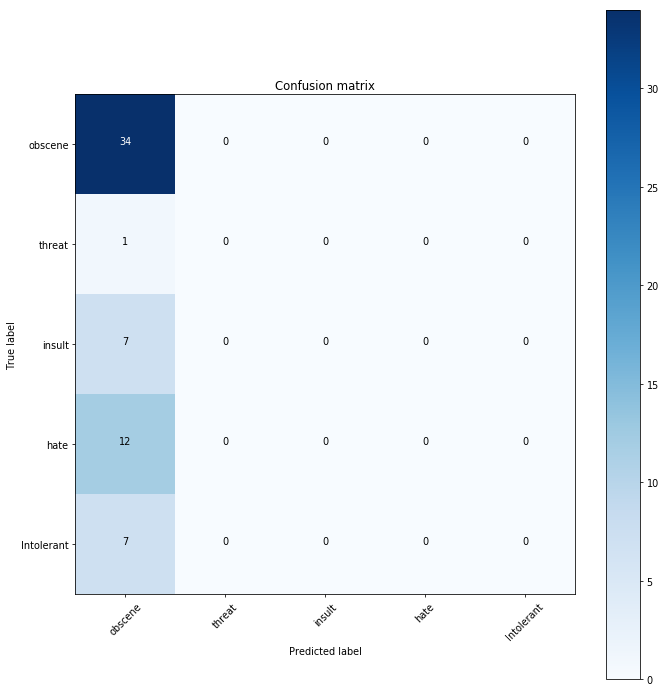

In [30]:
plot_confusion_matrix(ConfusionMatrix, classes=all_categories, title='Confusion matrix')
plt.show()